## Basic Bayesian Optimization
In this tutorial we demonstrate the use of Xopt to preform Bayesian Optimization on a
 simple test problem.

## Define the test problem
Here we define a simple optimization problem, where we attempt to minimize the sin
function in the domian [0,2*pi]. Note that the function used to evaluate the
objective function takes a dictionary as input and returns a dictionary as the output.

In [1]:
from xopt.vocs import VOCS
import math

# define variables and function objectives
vocs = VOCS(
    variables={"x": [0, 2 * math.pi]},
    objectives={"f": "MINIMIZE"},
)

In [2]:
# define a test function to optimize
import numpy as np

def sin_function(input_dict):
    # return multiple noisy measurements
    return {"f": np.sin(input_dict["x"]) + 0.5*np.random.randn(5),
            "dummy": np.random.randn(5)}

## Create Xopt objects
Create the evaluator to evaluate our test function and create a generator that uses
the Upper Confidence Bound acquisition function to perform Bayesian Optimization.

In [3]:
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt import Xopt

evaluator = Evaluator(function=sin_function)
gp_constructor = StandardModelConstructor(use_low_noise_prior=False)
generator = UpperConfidenceBoundGenerator(vocs=vocs, gp_constructor=gp_constructor)
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

## Generate and evaluate initial points
To begin optimization, we must generate some random initial data points. The first call
to `X.step()` will generate and evaluate a number of randomly points specified by the
 generator. Note that if we add data to xopt before calling `X.step()` by assigning
 the data to `X.data`, calls to `X.step()` will ignore the random generation and
 proceed to generating points via Bayesian optimization.

In [4]:
# call X.random_evaluate() to generate + evaluate 3 initial points
X.random_evaluate(2)

# inspect the gathered data
X.data

x         f     dummy  xopt_runtime  xopt_error
0  4.619338 -0.011513 -0.240742      0.000059       False
1  4.619338 -1.435161  0.829753      0.000059       False
2  4.619338 -1.476094  0.164653      0.000059       False
3  4.619338 -0.778552 -1.198242      0.000059       False
4  4.619338 -1.260215   0.00147      0.000059       False
5  0.759449  0.098461    -0.324      0.000148       False
6  0.759449  1.567489 -0.311139      0.000148       False
7  0.759449  0.164153  0.022538      0.000148       False
8  0.759449  0.566114 -1.265313      0.000148       False
9  0.759449  0.379249  1.293033      0.000148       False

## Do bayesian optimization steps
To perform optimization we simply call `X.step()` in a loop. This allows us to do
intermediate tasks in between optimization steps, such as examining the model and
acquisition function at each step (as we demonstrate here).

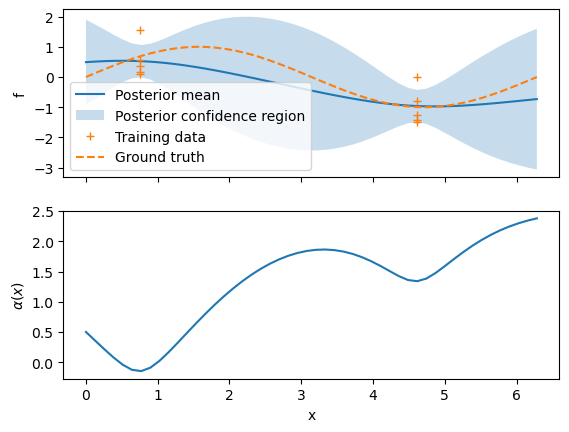

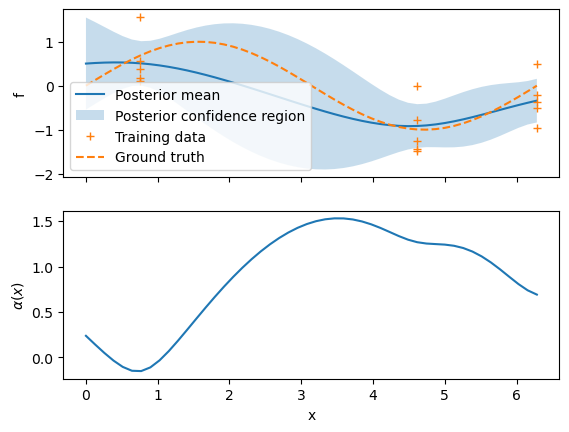

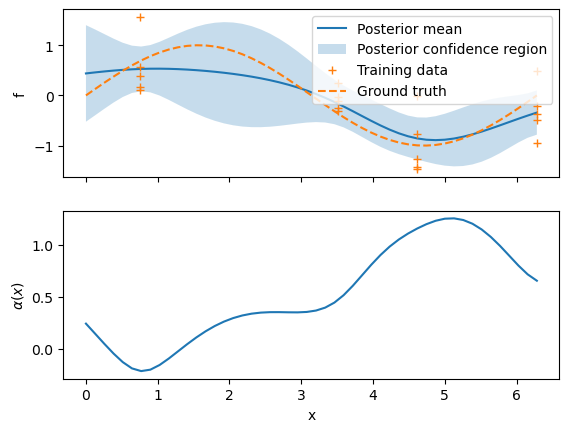

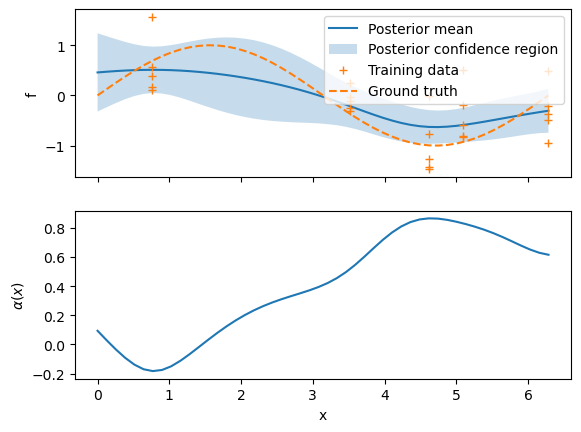

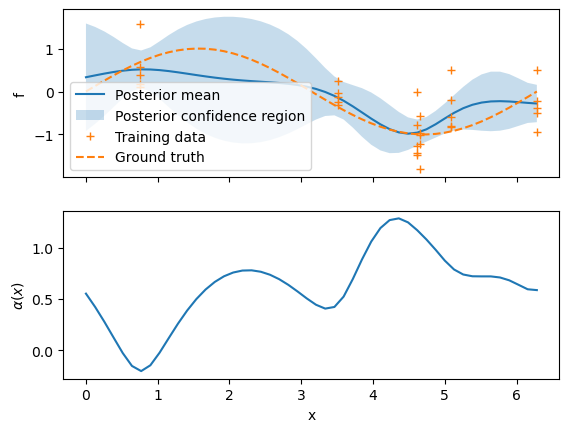

In [5]:
import torch
import matplotlib.pyplot as plt

n_steps = 5

# test points for plotting
test_x = torch.linspace(*X.vocs.bounds.flatten(), 50).double()

for i in range(n_steps):
    # get the Gaussian process model from the generator
    model = X.generator.train_model()

    # get acquisition function from generator
    acq = X.generator.get_acquisition(model)

    # calculate model posterior and acquisition function at each test point
    # NOTE: need to add a dimension to the input tensor for evaluating the
    # posterior and another for the acquisition function, see
    # https://botorch.org/docs/batching for details
    # NOTE: we use the `torch.no_grad()` environment to speed up computation by
    # skipping calculations for backpropagation
    with torch.no_grad():
        posterior = model.posterior(test_x.unsqueeze(1))
        acq_val = acq(test_x.reshape(-1, 1, 1))

    # get mean function and confidence regions
    mean = posterior.mean
    l,u = posterior.mvn.confidence_region()

    # plot model and acquisition function
    fig,ax = plt.subplots(2, 1, sharex="all")

    # plot model posterior
    ax[0].plot(test_x, mean, label="Posterior mean")
    ax[0].fill_between(test_x, l, u, alpha=0.25, label="Posterior confidence region")

    # add data to model plot
    ax[0].plot(X.data["x"], X.data["f"], "C1+", label="Training data")

    # plot true function
    true_f = np.sin(test_x)
    ax[0].plot(test_x, true_f,'--', label="Ground truth")

    # add legend
    ax[0].legend()

    # plot acquisition function
    ax[1].plot(test_x, acq_val.flatten())

    ax[0].set_ylabel("f")
    ax[1].set_ylabel(r"$\alpha(x)$")
    ax[1].set_xlabel("x")

    # do the optimization step
    X.step()


In [6]:
# access the collected data
X.data

x         f     dummy  xopt_runtime  xopt_error
0   4.619338 -0.011513 -0.240742      0.000059       False
1   4.619338 -1.435161  0.829753      0.000059       False
2   4.619338 -1.476094  0.164653      0.000059       False
3   4.619338 -0.778552 -1.198242      0.000059       False
4   4.619338 -1.260215   0.00147      0.000059       False
5   0.759449  0.098461    -0.324      0.000148       False
6   0.759449  1.567489 -0.311139      0.000148       False
7   0.759449  0.164153  0.022538      0.000148       False
8   0.759449  0.566114 -1.265313      0.000148       False
9   0.759449  0.379249  1.293033      0.000148       False
10  6.283185 -0.379428  0.022686      0.000026       False
11  6.283185 -0.950938  1.781889      0.000026       False
12  6.283185 -0.217578  1.103808      0.000026       False
13  6.283185  -0.49596  0.664795      0.000026       False
14  6.283185  0.495998  0.102054      0.000026       False
15  3.518793 -0.039908  1.050478      0.000024       False
16  3.518793 -0.305294 -1.451714      0.000024       False
17  3.518793 -0.118421 -0.343997      0.000024       False
18  3.518793  0.237909 -0.975853      0.000024       False
19  3.518793 -0.252254  0.356771      0.000024       False
20  5.088307  0.497992  1.191994      0.000020       False
21  5.088307  -0.81322  0.479879      0.000020       False
22  5.088307 -0.590264  -0.02449      0.000020       False
23  5.088307 -0.194415  0.165368      0.000020       False
24  5.088307 -0.831174   1.86811      0.000020       False
25  4.650385  -1.00841  1.160027      0.000021       False
26  4.650385 -0.580665   0.59192      0.000021       False
27  4.650385 -1.230013  1.190219      0.000021       False
28  4.650385 -1.815493 -0.075334      0.000021       False
29  4.650385 -0.962873 -0.103079      0.000021       False
30  4.331677 -0.804609  0.160299      0.000019       False
31  4.331677 -0.381751 -0.097682      0.000019       False
32  4.331677  0.177958  0.100419      0.000019       False
33  4.331677 -0.983582  0.611655      0.000019       False
34  4.331677  0.090901 -0.912519      0.000019       False

## Getting the optimization result
To get the best point (without evaluating it) we ask the generator to
predict the optimum based on the posterior mean.

In [7]:
X.generator.get_optimum()

x
0  4.496265

## Customizing optimization
Each generator has a set of options that can be modified to effect optimization behavior

In [8]:
X.generator.dict()

{'model': ModelListGP(
   (models): ModuleList(
     (0): SingleTaskGP(
       (likelihood): GaussianLikelihood(
         (noise_covar): HomoskedasticNoise(
           (noise_prior): GammaPrior()
           (raw_noise_constraint): GreaterThan(1.000E-04)
         )
       )
       (mean_module): ConstantMean()
       (covar_module): ScaleKernel(
         (base_kernel): MaternKernel(
           (lengthscale_prior): GammaPrior()
           (raw_lengthscale_constraint): Positive()
         )
         (outputscale_prior): GammaPrior()
         (raw_outputscale_constraint): Positive()
       )
       (outcome_transform): Standardize()
       (input_transform): Normalize()
     )
   )
   (likelihood): LikelihoodList(
     (likelihoods): ModuleList(
       (0): GaussianLikelihood(
         (noise_covar): HomoskedasticNoise(
           (noise_prior): GammaPrior()
           (raw_noise_constraint): GreaterThan(1.000E-04)
         )
       )
     )
   )
 ),
 'n_monte_carlo_samples': 128,
 'turbo_